In [7]:
import numpy as np
from fears.utils import AutoRate
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit

od_path = '../calibration_data/calibration_05172023/EK_single_OD600_20230517_154009_no_lid.xlsx'
p_od = AutoRate.Plate(od_path,mode='single_measurement')
od_data = p_od.od_data_to_dict(p_od.data)

In [8]:
cell_count_raw = np.zeros((3,4))

# experimentally observed cell count valies
cell_count_raw[:,0] = [163,322,194] 
cell_count_raw[:,1] = [74,70,72]
cell_count_raw[:,2] = [22,11,15]
cell_count_raw[:,3] = [4,9,6]

cell_count_raw = (cell_count_raw*10**5)/50

cell_count_avg = np.mean(cell_count_raw,axis=0)
cell_count_std = np.std(cell_count_raw,axis=0)
cell_count_err = cell_count_std/np.sqrt(3)

In [9]:
# background subtract od data

row_list = ['A','B','C','D','E','F','G','H']
bg_cols = [1,12]
bg_cols = [str(c) for c in bg_cols]

bg_est = 0
indx = 0
for row in row_list:
    for col in bg_cols:
        key = row + col
        bg_est += od_data[key]
        indx+=1

bg_est = bg_est/indx

col_list = np.arange(12) + 1
col_list = [str(c) for c in col_list]

od_t = np.zeros((len(row_list)-2,len(col_list)-2))
row_indx = 0
for row in row_list[1:-1]:
    col_indx = 0
    for col in col_list[1:-1]:
        key = row+col
        # od_data[key] = od_data[key] - bg_est
        od_t[row_indx,col_indx] = od_data[key] -  bg_est
        col_indx += 1

    row_indx += 1

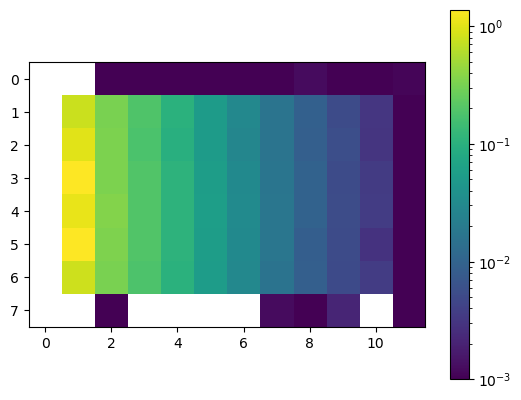

In [11]:
od_raw = np.zeros((len(row_list),len(col_list)))
od_all = np.zeros((len(row_list),len(col_list)))
row_indx = 0
for row in row_list:
    col_indx = 0
    for col in col_list:
        key = row+col
        od_all[row_indx,col_indx] = od_data[key] - bg_est
        od_raw[row_indx,col_indx] = od_data[key]
        col_indx += 1
    row_indx += 1


fig,ax = plt.subplots()

norm = colors.LogNorm(vmin=0.001, vmax=od_all.max())
im = ax.imshow(od_all,cmap='viridis',norm=norm)

fig.colorbar(im,ax=ax)

Text(0.05, 0.6, 'Intercept: 13.53')

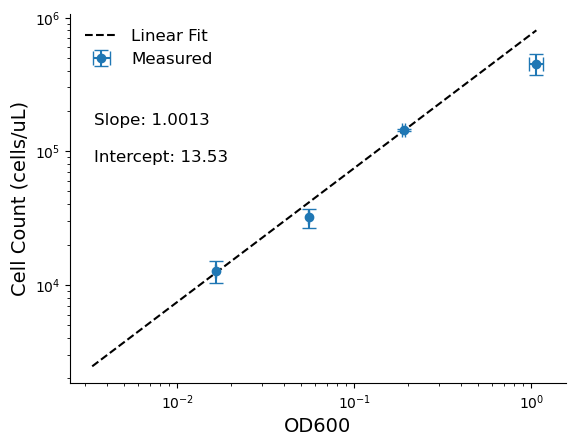

In [19]:
od_avg = np.mean(od_t,axis=0)
od_std = np.std(od_t,axis=0)
od_err = od_std/np.sqrt(len(row_list)-2)

od_measured = od_avg[[0,2,4,6]]
od_measured_err = od_err[[0,2,4,6]] 

# plot OD vs cell count

fig,ax = plt.subplots()

ax.errorbar(od_measured,cell_count_avg,yerr=cell_count_err,xerr=od_measured_err,
            fmt='o',capsize=5,label='Measured')
ax.set_yscale('log')
ax.set_xscale('log')

# extrapolate OD data

dilution = []
for i in range(len(col_list)-2):
    dilution.append(1/(2**i))

dilution = np.array(dilution)
cell_count_extrap = dilution*cell_count_avg[0]

# fit a linear model to log-log data

def linear(x,m,b):
    return m*x + b

xdata = np.log(od_measured)

popt,pcov = curve_fit(linear,np.log(od_measured),np.log(cell_count_avg),sigma=cell_count_err/np.log(cell_count_avg),absolute_sigma=True)

m = popt[0]
b = popt[1]

xfit = np.linspace(np.min(od_avg),np.max(od_avg),100)
yfit = np.exp(linear(np.log(xfit),m,b))

ax.plot(xfit,yfit,'k--',label='Linear Fit')

ax.set_xlabel('OD600',fontsize=14)
ax.set_ylabel('Cell Count (cells/uL)',fontsize=14)

ax.legend(fontsize=12,frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# annotate slope and intercept
ax.annotate('Slope: {:.4f}'.format(m),xy=(0.05,0.7),xycoords='axes fraction',fontsize=12)
ax.annotate('Intercept: {:.2f}'.format(b),xy=(0.05,0.6),xycoords='axes fraction',fontsize=12)